In [3]:
import numpy as np
import pandas as pd
import random
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set()

In [1]:
#the function below takes a state as a string and return it's correspondant index to be used for
# Q and R matrix
def elements_freq_list(a_list):
    d = {x:a_list.count(x) for x in a_list}
    elements=d.keys()
    freqs=d.values()
    return elements,freqs
def not_intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value not in lst2] 
    return lst3
def find(state):
    return list_of_states.index(state)
def clean_RDF(reward_going_to_action):
    R_matrix=np.array([[np.nan for a in all_routes.keys()] for s in all_routes.keys()])
#     for i in range(0,41):
#         R_matrix[i,i]=reward_going_to_self
    R_DF=pd.DataFrame(data=R_matrix,index=all_routes.keys(),columns=all_routes.keys())
    for start in all_routes.keys():
        list_of_connections=all_routes[start]
        R_DF.loc[start][list_of_connections]=reward_going_to_action
    return R_DF
def make_DF(matrix):
    return pd.DataFrame(data=matrix,index=all_routes.keys(),columns=all_routes.keys())

def create_environment(reward_action=-1):
    R_DF=clean_RDF(reward_action)
    R_matrix=R_DF.values
    Q_matrix=np.zeros(R_matrix.shape)
    return R_DF,R_matrix,Q_matrix

def plot_CUM_rewards_changes(list_results):
    fig=plt.figure()
    ax1=fig.add_subplot(121)
    ax2=fig.add_subplot(122)
    for res in list_results:
        cum_changes=res[-2]
        cum_rewards=res[-3]
        eps=res[-6]
        ax1.set_title('cummulative changes in Q-Matrix')
        plt.legend()
        ax2.plot(eps,cum_rewards)
        ax2.set_title('cummulative rewards earned')
def plot_agent_learning(results):
    _,rewards,changes_in_Q_matrix,movements,ROM,eps,convergence_m,outcome,cum_rewards,cum_changes,info=results
    fig=plt.figure(figsize=(20,5))
    fig.suptitle(info,fontsize=17)
    ax2=fig.add_subplot(141)
    ax2.plot(eps,changes_in_Q_matrix)
    ax2.set_title('sum of changes in Q matrix')
    plt.xlabel('episodes')
    plt.ylabel('changes in Q')
    ax1=fig.add_subplot(142)
    ax1.plot(eps,rewards)
    ax1.set_title('rewards earned')
    plt.xlabel('episodes')
    plt.ylabel('rewards')
    ax3=fig.add_subplot(143)
    ax3.plot(eps,movements)
    plt.xlabel('episodes')
    plt.ylabel('movements')
    ax3.set_title('number of movements')
    ax4=fig.add_subplot(144)
    res,freq=elements_freq_list(outcome)
    ax4.bar(res,freq)
    plt.ylabel('episodes')
    ax4.set_title('outcome')

#     ax5=fig.add_subplot(155)
# #     res,freq=elements_freq_list(outcome)
# #     ax4.bar(res,freq)
#     ax5.plot(eps,cum_rewards)
#     plt.ylabel('episodes')
#     ax4.set_title('cummulative rewards')
    


initiating the environment constants

In [5]:
all_routes={'paddington':'edgware road',
           'edgware road':['marylebone','paddington'],
           'marylebone':['edgware road','baker street'],
           'baker street': ['marylebone',"regent's park","bond street"],
            "regent's park":['oxford circus','baker street'],
            'piccadilly circus':['oxford circus','charing cross','green park','leicester square'],
            'charing cross':['embankment','leicester square','piccadilly circus'],
            'embankment':['waterloo','charing cross'],
            'waterloo':['elephant and castle','southwark' ,'embankment','westminster'],
            "earl's court":'gloucester road',
            'gloucester road':['south kensington',"earl's court"],
            'south kensington':['knightsbridge','gloucester road'],
            'knightsbridge':['hyde park corner','south kensington'],
            'hyde park corner':['green park','knightsbridge'],
            'green park':['westminster','victoria','bond street','hyde park corner','piccadilly circus',
                         'oxford circus'],
            'leicester square':['covent garden','piccadilly circus','charing cross',
                                'tottenham court road'],
            'covent garden':['leicester square','holborn'],
            'holborn':['covent garden','tottenham court road','chancery lane','russel square'],
            'notting hill':'queensway',
            'queensway':['leicester square','notting hill'],
            'lancaster gate':['marble arch','queensway'],
            'marble arch':['bond street','lancaster gate'],
            'bond street':['oxford circus','marble arch','baker street','green park'],
            'oxford circus':['bond street',"regent's park",'tottenham court road','piccadilly circus',
                            'green park','warren street'],
            'tottenham court road':['oxford circus','holborn','leicester square','goodge street'],
            'holborn':['chancery lane','tottenham court road'],
            'chancery lane':['holborn','st.pauls'],
            'st.pauls':['bank','chancery lane'],
            'bank':['st.pauls','liverpool street'],
            'liverpool street':'bank',
            'vauxhall':'pimlico',
            'pimlico':['victoria','vauxhall'],
            'victoria':['green park','pimlico'],
            'green park':['victoria','oxford circus','piccadilly circus','hyde park corner',
                         'bond street','westminster'],
           
            'warren street':['oxford circus','euston','goodge street'],
            'euston':['warren street',"king's cross"],
            'goodge street':['warren street','tottenham court road'],
            'westminster':['green park','waterloo'],
            'southwark':['waterloo','london bridge'],
           'london bridge':'southwark',
           'russel square':'holborn',
           "king's cross":['euston','russel square'],
           'elephant and castle':'waterloo'}



In [6]:
list_of_states=list(all_routes.keys())

In [7]:
def train_AGENT(epsilon=0.99
                ,epsilon_decay_rate=0.99
                ,alpha=1
                ,gamma=0.8
                ,number_episodes=200
                ,number_of_movements_per_episode=200
                ,destination_type='random'
                ,learning_policy='epsilon-greedy'
                ,reward_going_to_action=-1
                ,reward_going_to_destination=100
                ,min_epsilon=0.01):
#     reward_going_to_self=-10
    i_eps=epsilon
    R_DF,R_matrix,Q_matrix=create_environment(reward_going_to_action)
    rewards_measurements=[]
    #it's a way to monitor convergence of the Q matrix 
    changes_per_episode=[] 
    episodes=[]
    movements_per_episode=[]
    rewards_over_movements=[]
    outcome=[]
    cummulative_rewards=[]
    cummulative_changes=[]
    #hyperparameters

    list_of_states=list(all_routes.keys())
    if destination_type=='random':
        destination=random.choice(list_of_states)
    else:
        destination=destination_type
    R_DF.loc[R_DF[destination]==reward_going_to_action,destination]=reward_going_to_destination
    
    print('going to :{}'.format(destination))
    R_matrix=R_DF.values
    for episode in range(number_episodes):

        state=random.choice(list_of_states)
        while state==destination:
            state=random.choice(list_of_states)
        initial_state=state
        state_ind=find(state)
        rewards_per_episode=0
        changes=0
        #starting the episodes loop
        logs=[]

        for movement in range(number_of_movements_per_episode):
            possible_actions_ind=np.where(~np.isnan(R_matrix[state_ind]))[0]
            possible_actions=[]
            logs.append('starting from {}'.format(state))
            logs.append('destination is {}'.format(destination))
            for act_pos in possible_actions_ind:
                possible_actions.append(list_of_states[act_pos])
    #         print('all possible actions from {} are :'.format(list_of_states[state_ind]))
    #         print(possible_actions)
            logs.append('possible actions {}'.format(possible_actions))
            possible_actions=np.array(possible_actions)

            Q_values_of_possible_actions=Q_matrix[state_ind,possible_actions_ind]

    #         print('the possible actions have these Q values '.format(Q_values_of_possible_actions))
    #         print(Q_values_of_possible_actions)
            
            logs.append('the rewards for the actions are {}'.format(Q_values_of_possible_actions))
            
            
            best_actions=possible_actions_ind[np.where(Q_values_of_possible_actions==
                                                   np.max(Q_values_of_possible_actions))]

            best_actions_Q=[Q_matrix[state_ind,x] for x in best_actions]

    #         if len(best_actions)>1:
    #             print('multiple actions from state {} have the maximum q value. we will select a random action among these'.format(state))
    #             print('best available actions are {} with a value of {}'.format(
    #                 [list_of_states[x] for x in best_actions],best_actions_Q))

            if learning_policy != 'random':
                if learning_policy == 'epsilon-greedy':
                    if np.random.uniform() > 1-epsilon:
                        a=np.random.choice(possible_actions_ind)
            #             print('Selecting random action :{} with current Q :{}'.format(list_of_states[a],Q_matrix[state_ind,a]))
                        logs.append('selecting a random action {} with current Q value : {}'.format(list_of_states[a],Q_matrix[state_ind,a]))
                    else:
                        a=np.random.choice(best_actions)
            #             print('Selecting Greedy action :{} with current Q value :{}'.format(list_of_states[a],Q_matrix[state_ind,a]))
                        logs.append('Selecting greedily the action : {} with current Q value : {}'.format(list_of_states[a],Q_matrix[state_ind,a]))
                elif learning_policy== 'greedy':
                    a=np.random.choice(best_actions)
            else:
                a=np.random.choice(possible_actions_ind)


            reward=R_matrix[state_ind,a]
            rewards_per_episode+=reward
    #         print("Reward for taking action '{}' from state '{}': {}".format(list_of_states[a],
    #                                                                          list_of_states[state_ind],
    #                                                                          reward))

            logs.append('Reward for taking action {} from state {}: {}'.format(list_of_states[a],
                                                                              list_of_states[state_ind],
                                                                              reward))
            old_state=state_ind

            state_ind=a

    #         print('after taking an action :{} from state :{} the new state is :{}'.format(
    #         list_of_states[a],list_of_states[old_state],list_of_states[state_ind]))
            
            logs.append('after taking the action :{} from state : {} the new state is :{}'\
                       .format(list_of_states[a],list_of_states[old_state],list_of_states[state_ind]))
            q_TD=Q_matrix[old_state,a] + alpha * (reward + gamma * np.max(Q_matrix[state_ind,:]) -
                                                 Q_matrix[old_state,a])

            old_Q = Q_matrix[old_state,a]
            Q_matrix[old_state,a]=q_TD


            update_value=q_TD - old_Q 

            changes+=update_value


            logs.append('Q value updates' \
                  "Q( {} , {} ) = Q( {} , {} ) + alpha * ( r ( {} , {} ) + gamma * max( Q [ {} ,:]) - Q[ {} ,  {} ])".format(
            list_of_states[old_state],list_of_states[a],list_of_states[old_state],
            list_of_states[a],list_of_states[old_state],list_of_states[a],list_of_states[state_ind],
            list_of_states[old_state],list_of_states[a]))


            logs.append("Q matrix update: " \
                  "Q( {} , {} ) = {} + {} * ( {} + {} * {} - {} ) = {}".format(
                list_of_states[old_state], list_of_states[a], Q_matrix[old_state,a].round(0),
                alpha, reward, gamma, np.max(Q_matrix[state_ind,:]).round(0), 
                Q_matrix[old_state,a].round(0), q_TD))

                
            if (movement % 10 ==0) or (movement == 1):
                with open('log_episode'+str(episode)+'.txt','w') as log:
                    for l in logs:
#                         log.write('action number : {}'.format(movement))
                        log.write(l)
                        log.write('\n')
            if list_of_states[state_ind] == destination:
                print("Goal state '{}' reached. Ending episode.".format(destination))
                print('The destination was reached after {} steps'.format(movement))
                print('the cumulative rewards for the episode ( {} to : {} ) is :{} '.format(initial_state,destination,
                                                                                             rewards_per_episode))
                outcome.append('reached')
                break
        epsilon*=epsilon_decay_rate
        if epsilon <min_epsilon:
            epsilon=min_epsilon
        
        rewards_measurements.append(rewards_per_episode)
        changes_per_episode.append(changes)
        episodes.append(episode)
        movements_per_episode.append(movement)
        rewards_over_movements.append(rewards_per_episode / movement)
        cummulative_rewards.append(sum(rewards_measurements))
        cummulative_changes.append(sum(changes_per_episode))
        
        if learning_policy == 'random':
            info='destination : {}. Policy : Random. Parameters : Discount Factor (G) :{}. Learning Rate (a) : {}'\
            .format(destination,gamma,alpha)
        elif learning_policy == 'epsilon-greedy':
            info='destination : {}. Policy is : Epsilon-Greedy. Parameters : Learning Rate : {}, Discount Factor : {}. Epsilon :{}. E-decay : {}.'\
            .format(destination,alpha,gamma,i_eps,epsilon_decay_rate)
        elif learning_policy == 'greedy':
            info='destination : {}. Policy is : Greedy. Parameters : Learning Rate {}, Discount Factor :{}'\
            .format(destination,alpha,gamma)
        if movement==number_of_movements_per_episode - 1:
            outcome.append('did not reach')
    convergence_measure=sum(changes_per_episode)
    return (Q_matrix,rewards_measurements,changes_per_episode,movements_per_episode,rewards_over_movements,episodes,convergence_measure,outcome,
            cummulative_rewards,cummulative_changes,info)


In [397]:
sum_of_actions=0
minimum_n_actions=[]
maximum_n_actions=[]
for s in (all_routes.keys()):
    if type(all_routes[s])== str:
        number_actions=1
    else:
        number_actions=len(all_routes[s])
    minimum_n_actions.append(number_actions)
    maximum_n_actions.append(number_actions)
    sum_of_actions+=number_actions

random

In [8]:
results_random=train_AGENT(number_episodes=100,number_of_movements_per_episode=100,destination_type='paddington',learning_policy='random')

going to :paddington
Goal state 'paddington' reached. Ending episode.
The destination was reached after 83 steps
the cumulative rewards for the episode ( notting hill to : paddington ) is :17.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 46 steps
the cumulative rewards for the episode ( warren street to : paddington ) is :54.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 33 steps
the cumulative rewards for the episode ( regent's park to : paddington ) is :67.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 59 steps
the cumulative rewards for the episode ( st.pauls to : paddington ) is :41.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 8 steps
the cumulative rewards for the episode ( baker street to : paddington ) is :92.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 13 steps
the cumulative rewar

C:\Users\dayil\Anaconda3\lib\site-packages\ipykernel_launcher.py:158: RuntimeWarning: divide by zero encountered in double_scalars


Goal state 'paddington' reached. Ending episode.
The destination was reached after 64 steps
the cumulative rewards for the episode ( gloucester road to : paddington ) is :36.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 34 steps
the cumulative rewards for the episode ( king's cross to : paddington ) is :66.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 53 steps
the cumulative rewards for the episode ( earl's court to : paddington ) is :47.0 


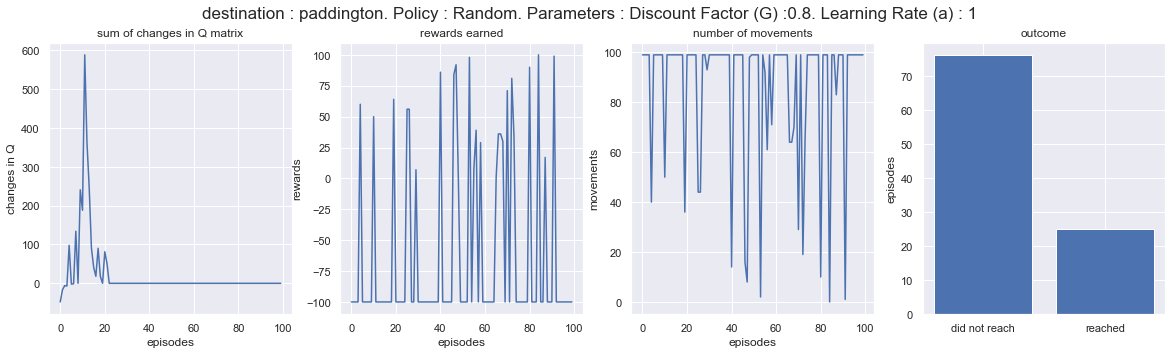

In [320]:
plot_agent_learning(results_random)

In [321]:
Q_matrix_random=results_random[0]
Q_matrix_random=make_DF(Q_matrix_random)

In [9]:
convergence_value_random=results_random[-5]
outcome_random=results_random[-4]

In [330]:
convergence_value_random

2169.9926834176003

epsilon greedy

In [10]:
results_epsilon=train_AGENT(number_episodes=100,number_of_movements_per_episode=100,destination_type='paddington')

going to :paddington
Goal state 'paddington' reached. Ending episode.
The destination was reached after 26 steps
the cumulative rewards for the episode ( knightsbridge to : paddington ) is :74.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 17 steps
the cumulative rewards for the episode ( covent garden to : paddington ) is :83.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 21 steps
the cumulative rewards for the episode ( embankment to : paddington ) is :79.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 36 steps
the cumulative rewards for the episode ( goodge street to : paddington ) is :64.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 99 steps
the cumulative rewards for the episode ( tottenham court road to : paddington ) is :1.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 69 steps
the cumul

Goal state 'paddington' reached. Ending episode.
The destination was reached after 17 steps
the cumulative rewards for the episode ( st.pauls to : paddington ) is :83.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 13 steps
the cumulative rewards for the episode ( piccadilly circus to : paddington ) is :87.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 40 steps
the cumulative rewards for the episode ( holborn to : paddington ) is :60.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 1 steps
the cumulative rewards for the episode ( marylebone to : paddington ) is :99.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 27 steps
the cumulative rewards for the episode ( oxford circus to : paddington ) is :73.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 20 steps
the cumulative rewards for the episode ( vau

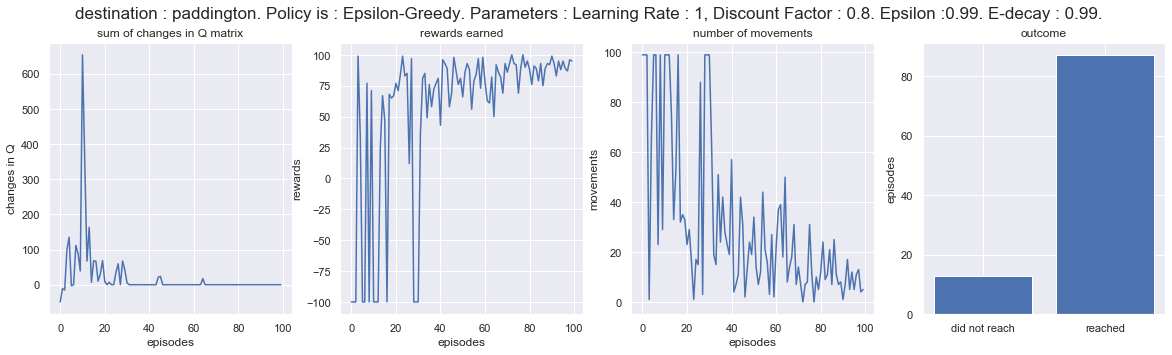

In [324]:
plot_agent_learning(results_epsilon)

In [325]:
Q_matrix_epsilon=results_epsilon[0]
Q_matrix_epsilon=make_DF(Q_matrix_epsilon)

In [328]:
convergence_value_epsilon=results_epsilon[-5]

In [329]:
convergence_value_epsilon

2169.9926834176017

In [274]:
vics=results_epsilon[-3]
elements_freq_list(vics)

(dict_keys(['reached', 'did not reach']), dict_values([90, 10]))

greedy

In [11]:
results_greedy=train_AGENT(number_episodes=100,number_of_movements_per_episode=100,destination_type='paddington',learning_policy='greedy')

going to :paddington
Goal state 'paddington' reached. Ending episode.
The destination was reached after 65 steps
the cumulative rewards for the episode ( pimlico to : paddington ) is :35.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 38 steps
the cumulative rewards for the episode ( goodge street to : paddington ) is :62.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 12 steps
the cumulative rewards for the episode ( oxford circus to : paddington ) is :88.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 14 steps
the cumulative rewards for the episode ( embankment to : paddington ) is :86.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 29 steps
the cumulative rewards for the episode ( vauxhall to : paddington ) is :71.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 11 steps
the cumulative rewards for

Goal state 'paddington' reached. Ending episode.
The destination was reached after 2 steps
the cumulative rewards for the episode ( baker street to : paddington ) is :98.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 8 steps
the cumulative rewards for the episode ( lancaster gate to : paddington ) is :92.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 6 steps
the cumulative rewards for the episode ( victoria to : paddington ) is :94.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 9 steps
the cumulative rewards for the episode ( elephant and castle to : paddington ) is :91.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 10 steps
the cumulative rewards for the episode ( earl's court to : paddington ) is :90.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 8 steps
the cumulative rewards for the episode

C:\Users\dayil\Anaconda3\lib\site-packages\ipykernel_launcher.py:158: RuntimeWarning: divide by zero encountered in double_scalars



The destination was reached after 4 steps
the cumulative rewards for the episode ( oxford circus to : paddington ) is :96.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 4 steps
the cumulative rewards for the episode ( oxford circus to : paddington ) is :96.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 0 steps
the cumulative rewards for the episode ( edgware road to : paddington ) is :100.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 8 steps
the cumulative rewards for the episode ( notting hill to : paddington ) is :92.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 8 steps
the cumulative rewards for the episode ( vauxhall to : paddington ) is :92.0 
Goal state 'paddington' reached. Ending episode.
The destination was reached after 13 steps
the cumulative rewards for the episode ( southwark to : paddington ) is :87.0 
Goal state 'p

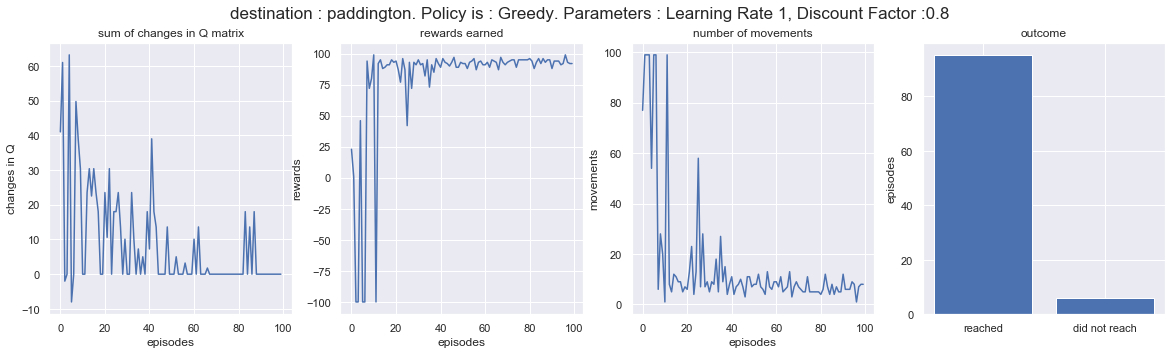

In [332]:
plot_agent_learning(results_greedy)

In [333]:
Q_matrix_greedy=results_greedy[0]
Q_matrix_greedy=make_DF(Q_matrix_greedy)

In [334]:
convergence_value_greedy=results_greedy[-5]

Text(0, 0.5, 'Cummulative Sum of Changes in Q-matrix')

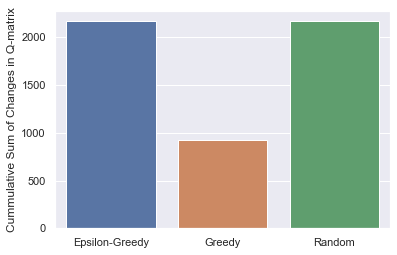

In [262]:
sns.barplot(x=['Epsilon-Greedy','Greedy','Random'],y=[convergence_value_epsilon,convergence_value_greedy,
                              convergence_value_random])
plt.ylabel('Cummulative Sum of Changes in Q-matrix')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


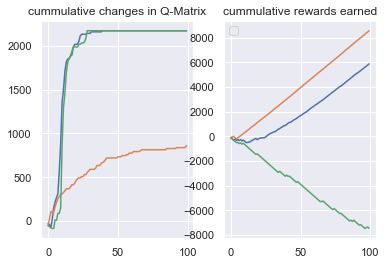

In [14]:
all_results=[results_epsilon,results_greedy,results_random]
plot_CUM_rewards_changes(all_results)

In [297]:
alphas=[0.1,0.5,0.9,1]
gammas=[0.1,0.5,0.9,1]

In [298]:
grid_results=[]
for a in alphas:
    grid_results.append(train_AGENT(alpha=a))

going to :notting hill
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 34 steps
the cumulative rewards for the episode ( baker street to : notting hill ) is :66.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 28 steps
the cumulative rewards for the episode ( knightsbridge to : notting hill ) is :72.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 17 steps
the cumulative rewards for the episode ( waterloo to : notting hill ) is :83.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 3 steps
the cumulative rewards for the episode ( bond street to : notting hill ) is :97.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 21 steps
the cumulative rewards for the episode ( warren street to : notting hill ) is :79.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 4 step

C:\Users\dayil\Anaconda3\lib\site-packages\ipykernel_launcher.py:158: RuntimeWarning: divide by zero encountered in double_scalars



The destination was reached after 56 steps
the cumulative rewards for the episode ( st.pauls to : notting hill ) is :44.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 16 steps
the cumulative rewards for the episode ( charing cross to : notting hill ) is :84.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 8 steps
the cumulative rewards for the episode ( marble arch to : notting hill ) is :92.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 11 steps
the cumulative rewards for the episode ( queensway to : notting hill ) is :89.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 53 steps
the cumulative rewards for the episode ( tottenham court road to : notting hill ) is :47.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 77 steps
the cumulative rewards for the episode ( gloucester road to : nott

Goal state 'notting hill' reached. Ending episode.
The destination was reached after 21 steps
the cumulative rewards for the episode ( victoria to : notting hill ) is :79.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 10 steps
the cumulative rewards for the episode ( charing cross to : notting hill ) is :90.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 9 steps
the cumulative rewards for the episode ( paddington to : notting hill ) is :91.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 7 steps
the cumulative rewards for the episode ( south kensington to : notting hill ) is :93.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 10 steps
the cumulative rewards for the episode ( knightsbridge to : notting hill ) is :90.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 16 steps
the cumulative rew

Goal state 'notting hill' reached. Ending episode.
The destination was reached after 8 steps
the cumulative rewards for the episode ( goodge street to : notting hill ) is :92.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 5 steps
the cumulative rewards for the episode ( hyde park corner to : notting hill ) is :95.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 7 steps
the cumulative rewards for the episode ( westminster to : notting hill ) is :93.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 16 steps
the cumulative rewards for the episode ( london bridge to : notting hill ) is :84.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 2 steps
the cumulative rewards for the episode ( marble arch to : notting hill ) is :98.0 
Goal state 'notting hill' reached. Ending episode.
The destination was reached after 7 steps
the cumulative re

Goal state 'westminster' reached. Ending episode.
The destination was reached after 79 steps
the cumulative rewards for the episode ( russel square to : westminster ) is :21.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 55 steps
the cumulative rewards for the episode ( baker street to : westminster ) is :45.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 10 steps
the cumulative rewards for the episode ( charing cross to : westminster ) is :90.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 7 steps
the cumulative rewards for the episode ( embankment to : westminster ) is :93.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 29 steps
the cumulative rewards for the episode ( hyde park corner to : westminster ) is :71.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 15 steps
the cumulative rewards f

Goal state 'westminster' reached. Ending episode.
The destination was reached after 5 steps
the cumulative rewards for the episode ( goodge street to : westminster ) is :95.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 13 steps
the cumulative rewards for the episode ( russel square to : westminster ) is :87.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 3 steps
the cumulative rewards for the episode ( covent garden to : westminster ) is :97.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 3 steps
the cumulative rewards for the episode ( marble arch to : westminster ) is :97.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 0 steps
the cumulative rewards for the episode ( waterloo to : westminster ) is :100.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 9 steps
the cumulative rewards for the ep

Goal state 'westminster' reached. Ending episode.
The destination was reached after 7 steps
the cumulative rewards for the episode ( marble arch to : westminster ) is :93.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 1 steps
the cumulative rewards for the episode ( southwark to : westminster ) is :99.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 12 steps
the cumulative rewards for the episode ( liverpool street to : westminster ) is :88.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 13 steps
the cumulative rewards for the episode ( gloucester road to : westminster ) is :87.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 4 steps
the cumulative rewards for the episode ( marble arch to : westminster ) is :96.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 1 steps
the cumulative rewards for th

Goal state 'westminster' reached. Ending episode.
The destination was reached after 9 steps
the cumulative rewards for the episode ( vauxhall to : westminster ) is :91.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 7 steps
the cumulative rewards for the episode ( queensway to : westminster ) is :93.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 1 steps
the cumulative rewards for the episode ( elephant and castle to : westminster ) is :99.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 4 steps
the cumulative rewards for the episode ( russel square to : westminster ) is :96.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 2 steps
the cumulative rewards for the episode ( marble arch to : westminster ) is :98.0 
Goal state 'westminster' reached. Ending episode.
The destination was reached after 2 steps
the cumulative rewards for the ep

Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 45 steps
the cumulative rewards for the episode ( notting hill to : lancaster gate ) is :55.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 73 steps
the cumulative rewards for the episode ( russel square to : lancaster gate ) is :27.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 56 steps
the cumulative rewards for the episode ( regent's park to : lancaster gate ) is :44.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 42 steps
the cumulative rewards for the episode ( gloucester road to : lancaster gate ) is :58.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 21 steps
the cumulative rewards for the episode ( warren street to : lancaster gate ) is :79.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached aft

Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 15 steps
the cumulative rewards for the episode ( notting hill to : lancaster gate ) is :85.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 9 steps
the cumulative rewards for the episode ( charing cross to : lancaster gate ) is :91.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 4 steps
the cumulative rewards for the episode ( knightsbridge to : lancaster gate ) is :96.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 11 steps
the cumulative rewards for the episode ( regent's park to : lancaster gate ) is :89.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 16 steps
the cumulative rewards for the episode ( edgware road to : lancaster gate ) is :84.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 20

Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 11 steps
the cumulative rewards for the episode ( vauxhall to : lancaster gate ) is :89.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 10 steps
the cumulative rewards for the episode ( liverpool street to : lancaster gate ) is :90.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 7 steps
the cumulative rewards for the episode ( earl's court to : lancaster gate ) is :93.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 9 steps
the cumulative rewards for the episode ( edgware road to : lancaster gate ) is :91.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 7 steps
the cumulative rewards for the episode ( russel square to : lancaster gate ) is :93.0 
Goal state 'lancaster gate' reached. Ending episode.
The destination was reached after 5 ste

Goal state 'marylebone' reached. Ending episode.
The destination was reached after 89 steps
the cumulative rewards for the episode ( piccadilly circus to : marylebone ) is :11.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 16 steps
the cumulative rewards for the episode ( green park to : marylebone ) is :84.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 72 steps
the cumulative rewards for the episode ( bond street to : marylebone ) is :28.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 192 steps
the cumulative rewards for the episode ( london bridge to : marylebone ) is :-92.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 61 steps
the cumulative rewards for the episode ( knightsbridge to : marylebone ) is :39.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 61 steps
the cumulative rewards for the e

The destination was reached after 28 steps
the cumulative rewards for the episode ( london bridge to : marylebone ) is :72.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 17 steps
the cumulative rewards for the episode ( warren street to : marylebone ) is :83.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 10 steps
the cumulative rewards for the episode ( notting hill to : marylebone ) is :90.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 11 steps
the cumulative rewards for the episode ( hyde park corner to : marylebone ) is :89.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 53 steps
the cumulative rewards for the episode ( euston to : marylebone ) is :47.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 9 steps
the cumulative rewards for the episode ( liverpool street to : marylebone ) is :91.0 
Go

Goal state 'marylebone' reached. Ending episode.
The destination was reached after 2 steps
the cumulative rewards for the episode ( green park to : marylebone ) is :98.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 8 steps
the cumulative rewards for the episode ( gloucester road to : marylebone ) is :92.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 5 steps
the cumulative rewards for the episode ( southwark to : marylebone ) is :95.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 2 steps
the cumulative rewards for the episode ( edgware road to : marylebone ) is :98.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 7 steps
the cumulative rewards for the episode ( tottenham court road to : marylebone ) is :93.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 7 steps
the cumulative rewards for the episode

Goal state 'marylebone' reached. Ending episode.
The destination was reached after 9 steps
the cumulative rewards for the episode ( st.pauls to : marylebone ) is :91.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 3 steps
the cumulative rewards for the episode ( victoria to : marylebone ) is :97.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 11 steps
the cumulative rewards for the episode ( elephant and castle to : marylebone ) is :89.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 4 steps
the cumulative rewards for the episode ( waterloo to : marylebone ) is :96.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 7 steps
the cumulative rewards for the episode ( embankment to : marylebone ) is :93.0 
Goal state 'marylebone' reached. Ending episode.
The destination was reached after 6 steps
the cumulative rewards for the episode ( euston to

In [ ]:
plot_agent_learning_2(results):

In [115]:
def plot_agent_learning_2(results):
    _,rewards,changes_in_Q_matrix,movements,ROM,eps,convergence_m,info=results
    fig=plt.figure(figsize=(22,6))
    fig.suptitle(info,fontsize=17)
    ax1=fig.add_subplot(131)
    ax1.plot(eps,rewards)
    plt.ylabel('rewards')
    plt.xlabel('episodes')
    ax1.set_title('rewards earned')
    ax2=fig.add_subplot(132)
    ax2.plot(eps,changes_in_Q_matrix)
    plt.xlabel('episodes')
    plt.ylabel('sum of changes in Q_matrix')
    ax2.set_title('sum of changes in Q matrix')
    ax3=fig.add_subplot(133)
    ax3.plot(eps,movements)
    plt.xlabel('episodes')
    plt.ylabel('number of movements')
    ax3.set_title('number of movements')
#     ax4=fig.add_subplot(224)
#     ax4.plot(eps,ROM)
#     ax4.set_title('rewards over number of movements')

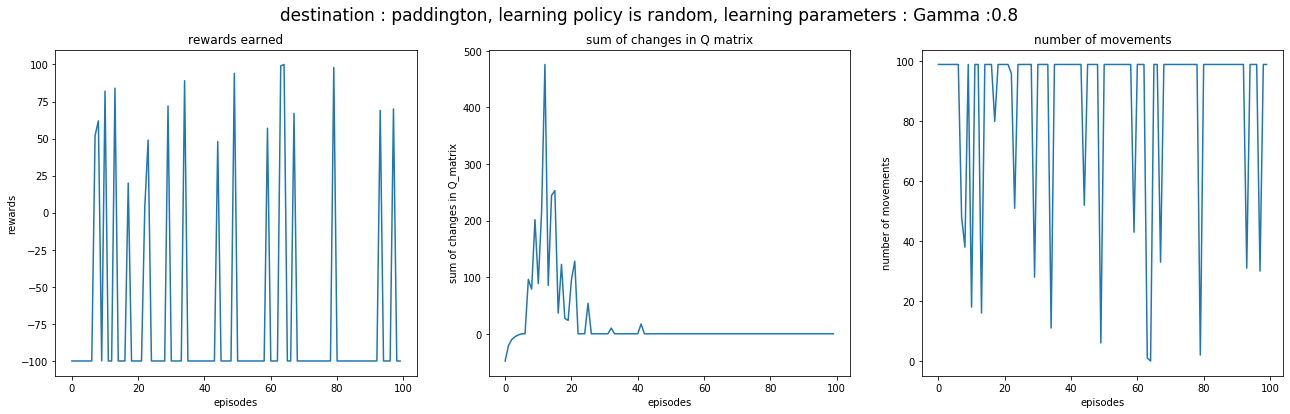

In [117]:
plot_agent_learning_2(results_random)